#Visualizing and understanding ConvNets (part 1)
In this Lab we will be experimenting with techniques for visualizing and understanding ConvNets.

The first part (part 1) is about simple visualization techniques:

- **Visualizing layer activations**
 - Typically used to monitor training. As training progresses, the layer activations (i.e., feature maps) should become more local and sparse in nature.
- **Visualizing filters**
 - Typically also used to monitor training. As training progresses, the filters should become nice and smooth. Noisy filters indicate that the network is not done training.
- **Inspecting fully connected layers with K-NN**
 - The fully connected (FC) layers are where the magic happens in CNN classifiers. However, it is hard to visualize what these layers have learned. One common approach is run K Nearest Neighbours (K-NN) using the learned feature representation. That is, for a given test image, compare with the nearest neighbours. Do they look similar? In what way are they similar?
- **Visualization of FC layers using dimensionality reduction**
 - Another way to visualize what the FC layers have learned is by means of dimensionality reduction on the learned feature representation. Today, we will be looking at t-SNE.

Part 1 of the lab is divided into to sub-parts:

- In task 1 to 5 we will demonstrate how to apply the techniques mentioned above on a pre-trained CNN. Specifically, we will be looking at VGG16.

- In the final task, you will apply the techniques to monitor training of a custom CNN classifier on the MNIST dataset.

Much of part 1 will be a recap of [Lab 2](https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2021/blob/main/Lab2_Solution.ipynb).

**Before we start - remember to set runtime to GPU**

# Task 1 - Inference using pre-trained VGG16
This task serves to get us started. We will download a test image and run it through a pre-trained VGG16 network.

### Mount your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Download a test image
Lets download an image to work on:

In [ ]:
import urllib.request

url = "https://raw.githubusercontent.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2021/main/data/cat.jpg"
urllib.request.urlretrieve(url,'/content/gdrive/My Drive/cat.jpg')

# Check that the file is in your Drive
!ls "/content/gdrive/My Drive/cat.jpg"

'/content/gdrive/My Drive/cat.jpg'


### Display test image

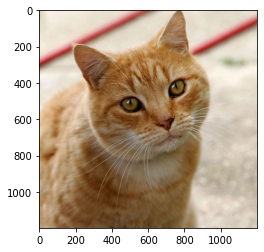

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image using OpenCV
img_path = '/content/gdrive/My Drive/cat.jpg'
img = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
plt.imshow(img);

### Set up VGG16
First, let's download and instantiate a pre-trained VGG16 network including the top layers (i.e., the classifier):

In [ ]:
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model

vgg16_full = VGG16(weights='imagenet',
                      include_top=True,
                      input_shape=(224, 224, 3))

# Uncomment one of the following to print network architecture:
#vgg16_full.summary()
#plot_model(vgg16_full)

### Preprocess the image
Recall that when using a pre-trained model, we have to make sure that we preprocess the input image in the same way as when the model was trained. In the case of VGG16, the correct preprocessing is to subtract a pre-calculated channel-wise mean given by `[103.939, 116.779, 123.68]`. Fortunately, Keras does that for us using the `preprocess_input` function.

np.min(img_data) 0.0
np.max(img_data) 255.0
np.min(img_preprocessed) -123.68
np.max(img_preprocessed) 133.061
img_preprocessed.shape (1, 224, 224, 3)


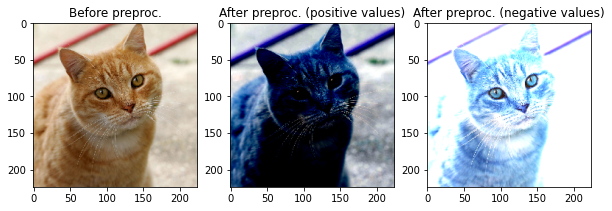

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0) # add extra batch dimension
img_preprocessed = preprocess_input(img_data.copy())

# Range before preprocessing
print('np.min(img_data)',np.min(img_data))
print('np.max(img_data)',np.max(img_data))

# Range after preprocessing
print('np.min(img_preprocessed)',np.min(img_preprocessed))
print('np.max(img_preprocessed)',np.max(img_preprocessed))

# Shapes
print('img_preprocessed.shape',img_preprocessed.shape)

plt.figure(figsize=(10,5))
plt.subplot(131); plt.imshow(img_data.squeeze()/255); plt.title('Before preproc.');
plt.subplot(132); plt.imshow(np.clip(img_preprocessed.squeeze()/128, a_min=0, a_max=1)); plt.title('After preproc. (positive values)');
plt.subplot(133); plt.imshow(np.clip(img_preprocessed.squeeze()/128, a_min=-1, a_max=0)+1); plt.title('After preproc. (negative values)');

### Classifiy test image
Let's run the classifier on the test image:

In [ ]:
from keras.applications.imagenet_utils import decode_predictions

# Predict class probabilities (model pre-trained on ImageNet, therefore 1000 classes)
predictions = vgg16_full.predict(img_preprocessed)
print('predictions.shape',predictions.shape)

# Get top-5 predictions
labels = decode_predictions(predictions,top=5)
[print(name,prob) for code, name, prob in labels[0]]

predictions.shape (1, 1000)
49152/35363 [=========================================] - 0s 0us/step
tiger_cat 0.41843152
Egyptian_cat 0.3616533
tabby 0.1262881
lynx 0.021717021
cup 0.008456161


[None, None, None, None, None]

Looks like the pre-trained VGG16 model predicts labels  associated with *cat*, as we would expect :-)

# Task 2 - Visualizing layer activations
Our goal is to visualize the layer activations or feature maps of all convolution layers. Show stats about convolution layers:

In [ ]:
for i, layer in enumerate(vgg16_full.layers):
  
  # check for convolutional layer
  layer_type = layer.__class__.__name__
  
  if 'Conv' not in layer_type:
    continue
  
  # get filter weights
  layer_name = layer.name
  input_shape = layer.input_shape
  output_shape = layer.output.shape
  filter_shape = layer.get_weights()[0].shape
  
  print(f"Layer {i} has name {layer_name}, input shape {input_shape}, filter shape {filter_shape}, and output shape {output_shape}")

Layer 1 has name block1_conv1, input shape (None, 224, 224, 3), filter shape (3, 3, 3, 64), and output shape (None, 224, 224, 64)
Layer 2 has name block1_conv2, input shape (None, 224, 224, 64), filter shape (3, 3, 64, 64), and output shape (None, 224, 224, 64)
Layer 4 has name block2_conv1, input shape (None, 112, 112, 64), filter shape (3, 3, 64, 128), and output shape (None, 112, 112, 128)
Layer 5 has name block2_conv2, input shape (None, 112, 112, 128), filter shape (3, 3, 128, 128), and output shape (None, 112, 112, 128)
Layer 7 has name block3_conv1, input shape (None, 56, 56, 128), filter shape (3, 3, 128, 256), and output shape (None, 56, 56, 256)
Layer 8 has name block3_conv2, input shape (None, 56, 56, 256), filter shape (3, 3, 256, 256), and output shape (None, 56, 56, 256)
Layer 9 has name block3_conv3, input shape (None, 56, 56, 256), filter shape (3, 3, 256, 256), and output shape (None, 56, 56, 256)
Layer 11 has name block4_conv1, input shape (None, 28, 28, 256), filter 

Note that you can get the layer names from the list above.

##Visualizing layer activations
Let's visualize the layer activations (i.e., feature maps) of the second conv layer in the first block:

Shape of feature map: (224, 224, 64)


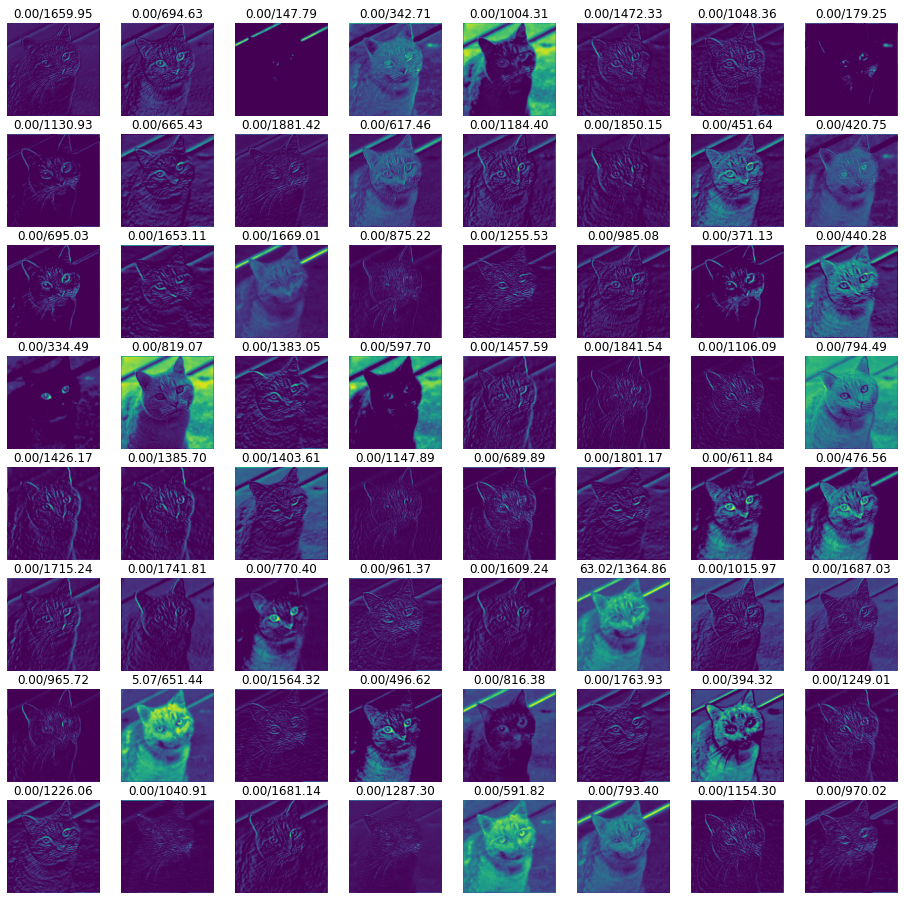

In [ ]:
from keras import Model
layer_name = 'block1_conv2'
dummy_model = Model(inputs=vgg16_full.input, outputs=vgg16_full.get_layer(layer_name).output)
out = dummy_model.predict(img_preprocessed)
out = out.squeeze()

num_channels = out.shape[-1]
height_width = out.shape[0]
num_cols = 8
num_rows = int(num_channels / num_cols)

print('Shape of feature map: ' + str(out.shape))

plt.figure(figsize=(16,2*num_rows))
for i in range(num_channels):
  f = out[:,:,i]
  plt.subplot(num_rows,num_cols,i+1)
  plt.imshow(f)
  plt.axis('off')
  plt.title("{0:.2f}".format(f.min()) + "/" + "{0:.2f}".format(f.max())) # Print min/max intensity

Visualization of layer activations is typically used to monitor the training process. As training progresses, the layer activations (i.e., feature maps) should become more local and sparse in nature. We can also use layer activations to get an understanding of what features the network has learned to look for - at least in the first few layers. As me move deeper and deeper into the network, it becomes increasingly harder to interpret the layer activations.

###Questions
Using layer activation visualization, answer the following questions:
1. What type of features are detected in the `block1_conv2` layer?
2. Are the features detected in the `block5_conv3` local and sparse, as we would expect?

# Task 3 - Visualizing filters
Filter visualization is typically also used to monitor training. As training progresses, the filters should become nice and smooth. On the other hand, noisy filters indicate that the network is not done training.

Note that each filter can have many channels that in general have to be displayed separately. However, for the first convolution layer, we know that there are only three channels (RGB). So in this case, we can display all channels of the filters simultaneously using an RGB images.

Since the gradients during backpropagation tend to be smallest in the first layer of the network, it us usually sufficient to inspect the filters of the first layer in order to verify that the network is done training (again, what we don't want to see is noisy filters).

Let's visualize the filters of the first convolution layer of VGG16:

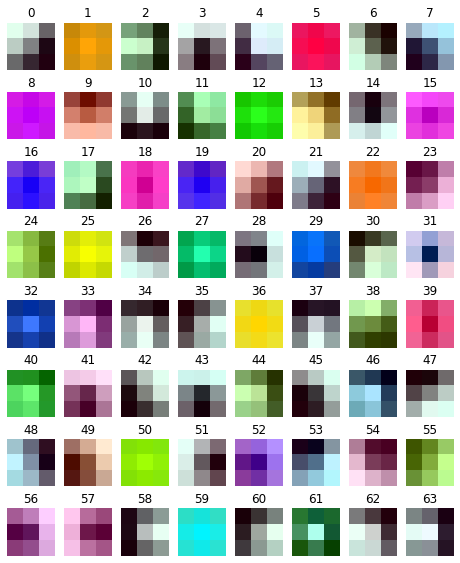

In [ ]:
layer_name = 'block1_conv1'
layer = vgg16_full.get_layer(layer_name)
filters = layer.get_weights()

plt.figure(figsize=(8,10))
for i in range(64):
  f = filters[0][:,:,:,i]
  
  # Normalize to range 0 ... 1
  f -= f.min()
  f /= f.max()
  
  plt.subplot(8,8,i+1)
  plt.imshow(f)
  plt.axis('off')
  plt.title(str(i))

###Questions
1. Do the filters look smooth and noise-free?
2. How would you visualize the filters of the last conv layer (`block5_conv3`)? Hint: There are 512 filters in the last layer, and each filter furthermore has 512 channels. Do you see the challenge in displaying the filters?

# Task 4 - Inspecting fully connected layers with K-NN
In a simple CNN classifier, the objective of the fully connected (FC) layers is to take the results of the convolution/pooling process and use them to classify the image into a label.

One way to inspect an FC layer is as follows:

1. Choose an FC layer. For VGG, FC layers output a 1000 or 4096-dimensional feature vector for each image.
2. Run the network on many images and collect the feature vectors.
3. Run K Nearest Neighbours (KNN).
4. For a given test image, compare with nearest neighbours. Do they look similar? In what way are they similar?

In this task we will be looking af the second FC layer of VGG16.

### Download more images
We need more images from multiple classes. We will be using the same approach as in [Lab 2](https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2021/blob/main/Lab2_Solution.ipynb) to download some example images:

In [ ]:
!pip install fastbook --quiet

     |████████████████████████████████| 720 kB 12.3 MB/s 
     |████████████████████████████████| 189 kB 48.0 MB/s 
     |████████████████████████████████| 1.2 MB 42.2 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 51 kB 311 kB/s 


In [ ]:
from fastbook import *
from pathlib import Path

root = '/content/gdrive/My Drive/' # Don't change this
#root = '/content/' # Alternative solution if mounting your Drive doesn't work
data_dirname = 'data' # Change as you like
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) # should "/content/gdrive/My Drive/data"

**IMPORTANT:** In case you still have data folders from Lab 2 with overlapping names **or** the download fails and you have to clear the data directory, **uncomment and run** these commands (remember to prefix with !):

```
!rm -rf "/content/gdrive/My Drive/data"
!mkdir "/content/gdrive/My Drive/data" # make new empty data directory
```



In [ ]:
classes = ['bird','cat','cow','dog','horse','mouse','pig','sheep']
max_images = 100
count = 0
for idx, category in enumerate(classes):
  print(category)
  folder = category
  dest = p/folder
  dest.mkdir(parents=True, exist_ok=True)
  urls = search_images_ddg(category, max_images=max_images)
  download_images(dest,urls=urls,max_pics=max_images)

bird
cat
cow
dog
horse
mouse
pig
sheep


Verify images (remove files that cannot be opened)

In [ ]:
import os
for c in classes:
  print(c)
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f)) 

bird
Failed to open /content/gdrive/My Drive/data/bird/00000047.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data/bird/00000078.jpg. Deleting file
cat
Failed to open /content/gdrive/My Drive/data/cat/00000017.gif. Deleting file
Failed to open /content/gdrive/My Drive/data/cat/00000025.jpg. Deleting file
cow
dog
Failed to open /content/gdrive/My Drive/data/dog/00000087.jpg. Deleting file
horse
mouse
pig
sheep
Failed to open /content/gdrive/My Drive/data/sheep/00000029.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data/sheep/00000039.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data/sheep/00000042.jpg. Deleting file


### Set up data generator
Make data generator that runs through all images:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
generator = datagen.flow_from_directory(str(p), # this is where you specify the path to the main data folder
                                        target_size=(224,224),
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=True)

Found 769 images belonging to 8 classes.


Verify that the generator classes and your classes are in the same order:

In [ ]:
print(generator.class_indices)
print(classes)

{'bird': 0, 'cat': 1, 'cow': 2, 'dog': 3, 'horse': 4, 'mouse': 5, 'pig': 6, 'sheep': 7}
['bird', 'cat', 'cow', 'dog', 'horse', 'mouse', 'pig', 'sheep']


### Modify model to output features from second FC layer
Here we are slightly modify the model. How (in what way)?


In [ ]:
from keras import activations
from keras.models import load_model

# New model that outputs features of second FC layer (fc2)
model = Model(inputs=vgg16_full.input, outputs=vgg16_full.get_layer('fc2').output)

features = model.predict(img_preprocessed)
print('Feature dimensions: ' + str(features.shape))

Feature dimensions: (1, 4096)


### Run K-NN
Extract 4096-dimensional feature vectors from second FC layer and run K Nearest Neighbors:

**NOTE:** Code block sometimes crashes. Just run it, until it doesn't crash...

In [ ]:
def extract_features(generator):
  generator.reset()
  raw_pixel_features_list = []
  vgg16_features_list = []
  labels_list = []
  batch_index = 0
  while batch_index <= generator.batch_index:
    # Load mini-batch
    raw_pixels, labels = generator.next()

    # Run through MobileNet encoder
    vgg16_features = model.predict(raw_pixels) # This is where we apply the CNN
    
    # Vectorize images
    bs,h,w,c = raw_pixels.shape
    raw_pixels = np.reshape(raw_pixels,(bs,h*w*c)) # vectorize
    
    # Convert one-hot encoding to class index
    labels = np.argmax(labels,axis=1)

    # Save in lists
    for i in range(bs):
      raw_pixel_features_list.append(raw_pixels[i])
      vgg16_features_list.append(vgg16_features[i])
      labels_list.append(labels[i])
      
    batch_index = batch_index + 1

  # Convert lists to numpy arrays
  raw_pixel_features = np.asarray(raw_pixel_features_list)
  vgg16_features = np.asarray(vgg16_features_list)
  labels = np.asarray(labels_list)

  return raw_pixel_features, vgg16_features, labels

features_raw, features_net, labels = extract_features(generator)

# Train K-NN classifier on network features (features_net) with k = 10
nbrs = neighbors.NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(features_net)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Count number of examples within each class (just a test - numbers should be fairly equal):

In [ ]:
for i in range(len(classes)):
  print(i,len(np.where(labels==i)[0]))

0 97
1 93
2 95
3 98
4 99
5 94
6 96
7 97


### Display results
Pick a random image and display its 10 closest neighbours:

File path: /content/gdrive/My Drive/data/bird/00000035.jpg
Input/query image:


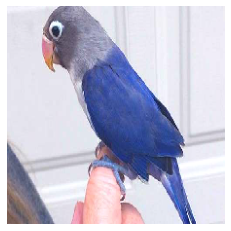

10 nearest neighbours:


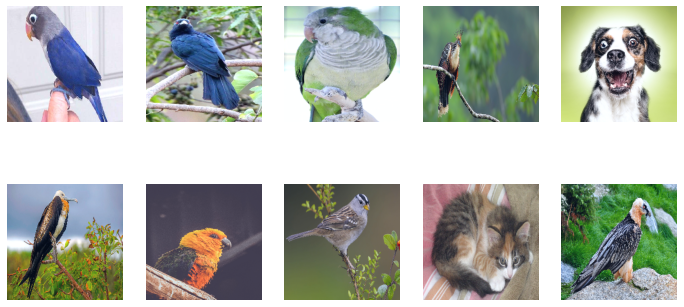

In [ ]:
# Pick test image
filelist = [x for x in (p/classes[np.random.randint(0,len(classes)-1)]).iterdir() if x.is_file()]
img_path = filelist[np.random.randint(0,len(filelist)-1)]
print(f"File path: {img_path}")

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

# Feed test image through network to get feature vector
X = model.predict(img_data)
X = np.reshape(X,(1,4096)) # Vectorize

# Get indicies of 10 nearest neighbours (+ distances)
distances, indices = nbrs.kneighbors(X)

# Display nearest neighbours
print('Input/query image:')
plt.figure()
im = (img_data[0,:,:,:]+128)/255
b,g,r = cv2.split(im)
rgb = cv2.merge((r,g,b))
plt.imshow(np.clip(rgb,0,1,out=rgb))
plt.imshow(rgb)
plt.axis('off')
plt.show()
print('10 nearest neighbours:')
plt.figure(figsize=(12,6))
for i in range(10):
  plt.subplot(2,5,i+1)
  im = (np.reshape(features_raw[indices[0][i],:],(224,224,3)) + 128) / 255
  b,g,r = cv2.split(im)
  rgb = cv2.merge((r,g,b))
  plt.imshow(np.clip(rgb,0,1,out=rgb))
  plt.axis('off')

###Questions
Recall that our goal is to investigate if the second FC layer has learned useful features. Run the above code block a few times and answer these questions:

1. What should we be looking for? In other words, what kind of similarity do you expect to see?
2. Are you happy with the results?

# Task 5 - Visualization of FC layers using dimensionality reduction
Another way to visualize the learned feature representation of an FC layer is to reduce the dimensionality of the feature vectors from, say 4096 to 2 dimensions (so that we can plot the features in 2D). Here, we will be using t-Distributed Stochastic Neighbouring Entities (t-SNE).

t-SNE minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding”.
As a result, **observations that are close in the high-dimensional space will also be close in the low-dimensional space**.

### Run t-SNE on extracted feature vectors

(769, 4096) (769,)
Size of the dataframe: (769, 4097)
Explained variation per principal component: [0.08744276 0.0565235  0.04666441]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 769 samples in 0.008s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 769 samples in 0.256s...
[t-SNE] Computed conditional probabilities for sample 769 / 769
[t-SNE] Mean sigma: 30.793511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.667778
[t-SNE] KL divergence after 300 iterations: 1.030237
t-SNE done! Time elapsed: 2.84842586517334 seconds


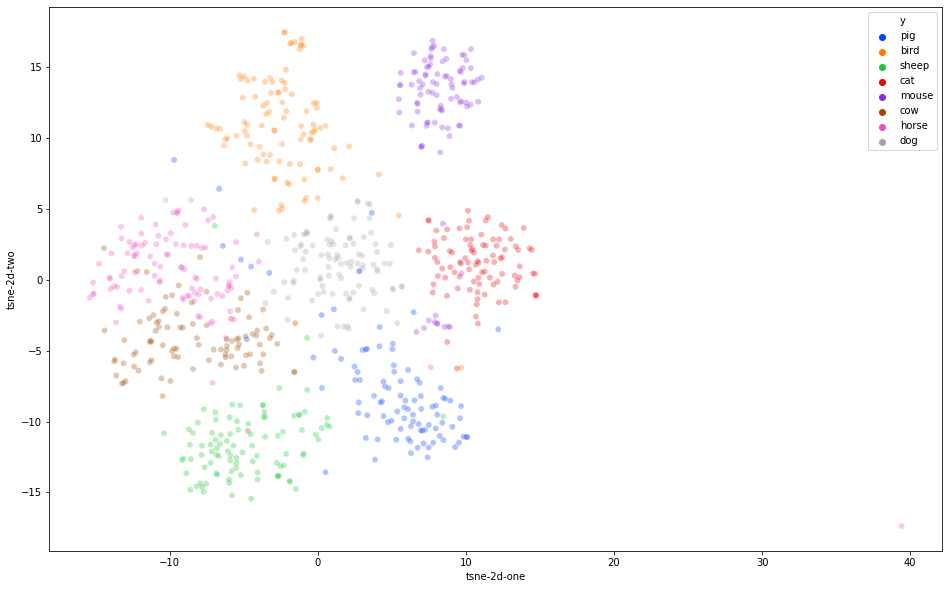

In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Same as above, but using neural net representation
X = features_net
y = labels
print(X.shape, y.shape)

feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['y'] = df['y'].apply(lambda i: classes[int(i)])
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

rndperm = np.random.permutation(df.shape[0])

N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("bright", len(classes)),
    data=df_subset,
    legend="full",
    alpha=0.3
)

###Questions
1. What can you say about the the topology of the learned representation?
2. Are any of the classes clearly separated from the others?
3. Which classes are likely confused more often than others?

# Task 6 - Try it on MNIST
Your task is to apply what you have learned above on a custom CNN classifier trained on MNIST.

### Download dataset

In [ ]:
from __future__ import print_function
from keras.datasets import mnist
from keras import backend as K

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Pre-process inputs
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class indices to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11501568/11490434 [==============================] - 0s 0us/step


### Set up custom CNN classifier
Note that the model is defined using a function call. Use this function if you need to re-initialize the model (i.e., reset all weights to random values).

Also note that the layers are given names like `conv1`, `pool1`, etc. You can use these names to access filters and feature maps of different layers.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from keras.layers import Input

def get_model():
  inputs = Input(shape=(28, 28, 1),name='input')

  # Encoder (convolutional base)
  x = Conv2D(8, kernel_size=(5, 5), activation='relu', name='conv1')(inputs)
  x = MaxPooling2D((2, 2),name='pool1')(x)
  x = Conv2D(16, kernel_size=(3, 3), activation='relu',name='conv2')(x)
  x = MaxPooling2D((2, 2),name='pool2')(x)
  x = Conv2D(32, kernel_size=(3, 3), activation='relu',name='conv3')(x)
  encoded = Flatten(name='flat')(x)

  # Decoder (2 fully connected layers)
  x = Dense(64, activation='relu',name='fc1')(encoded)
  x = Dropout(0.5,name='drop')(x)
  predictions = Dense(num_classes,activation='softmax',name='prediction')(x)

  # This creates a callable model that includes the Input layer and the prediction layer
  model = Model(inputs=inputs, outputs=predictions)
  
  return model

model = get_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 8)         208       
                                                                 
 pool1 (MaxPooling2D)        (None, 12, 12, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 10, 10, 16)        1168      
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 16)          0         
                                                                 
 conv3 (Conv2D)              (None, 3, 3, 32)          4640      
                                                                 
 flat (Flatten)              (None, 288)               0   

### Run inference on a random test image
**Note** that we haven't trained the model yet.

Class probabilities: [0.10580293 0.1049949  0.09464136 0.09143741 0.08938098 0.10633073 0.10627369 0.09279274 0.10900943 0.09933583]


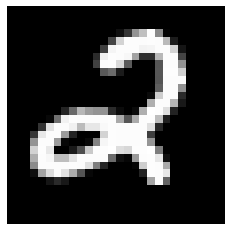

In [ ]:
N = x_test.shape[0]
ix = np.random.randint(N)
test_image = x_test[ix]
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)[0]
print('Class probabilities: ' + str(prediction))
plt.figure()
plt.imshow(test_image.squeeze(),cmap='gray')
plt.axis('off');

### Task
1. Display the filters of the first convolution layer (`conv1`).
2. Run the test image through the network (like above) and display the activations of the last convolution layer (`conv3`).
3. Optionally, repeat for multiple test images.

**Tip:** Define functions for both, as it will make the remaining sub-tasks easier.

Filters layer 1:


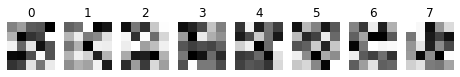

Activations layer 3:


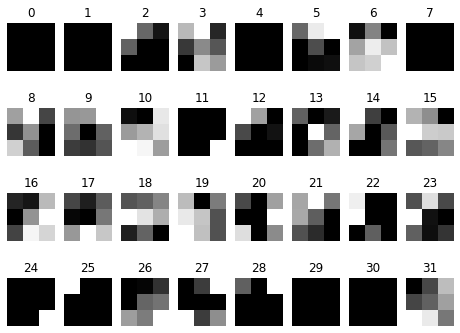

In [ ]:
def plot_filters_layer1(model):
  layer_name = 'conv1'
  layer = model.get_layer(layer_name)
  filters = layer.get_weights()
  print('Filters layer 1:')
  plt.figure(figsize=(8,10))
  for i in range(8):
    f = filters[0][:,:,:,i]
    
    # Normalize to range 0 ... 1
    f -= f.min()
    f /= f.max()
    
    plt.subplot(8,8,i+1)
    plt.imshow(f.squeeze(),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
  plt.show()

def plot_activations_layer3(model,test_image):
  layer_name = 'conv3'
  dummy_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
  out = dummy_model.predict(test_image)
  out = out.squeeze() # 3x3x32
  print('Activations layer 3:')
  plt.figure(figsize=(8,6))
  for i in range(32):
    f = out[:,:,i]
    plt.subplot(4,8,i+1)
    plt.imshow(f,cmap='gray')
    plt.axis('off')
    plt.title(str(i))
  plt.show()

plot_filters_layer1(model)
plot_activations_layer3(model,test_image)

### Questions
1. How would you characterize the filters? Are they smooth? Are they noisy?
2. How would you characterize the layer activations? Are they local and sparse?
3. Do you observe the same overall pattern in layer activations for different test images?

### Train the model for 1 epoch
Train the model for 1 epoch and display the filters and activations again.

In [ ]:
batch_size = 128
epochs = 1

# Compile the model before training
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model
history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

469/469 [==============================] - 6s 8ms/step - loss: 0.5464 - accuracy: 0.8250 - val_loss: 0.0974 - val_accuracy: 0.9689
Test loss: 0.09736613929271698
Test accuracy: 0.9689000248908997


Display filters and layer activations again:

Filters layer 1:


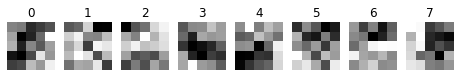

Activations layer 3:


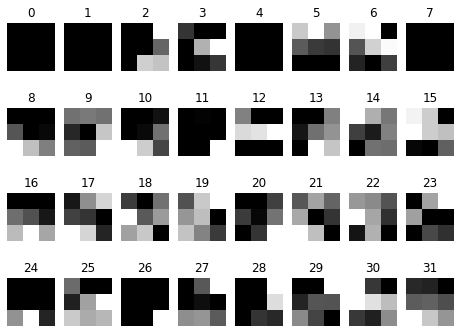

In [ ]:
plot_filters_layer1(model)
plot_activations_layer3(model,test_image)

### Question
Now taht we have trained the model, the filters and activations are not completely random anymore. Answer the same questions as before:

1. How would you characterize the filters? Are they smooth? Are they noisy?
2. How would you characterize the layer activations? Are they local and sparse?
3. Do you observe the same overall pattern in layer activations for different test images?

### Train for longer
Now, train for 20 epochs (or more if you want):

In [ ]:
epochs = 20

# Fit model
history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1693 - accuracy: 0.9508 - val_loss: 0.0683 - val_accuracy: 0.9796
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1235 - accuracy: 0.9650 - val_loss: 0.0499 - val_accuracy: 0.9845
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1032 - accuracy: 0.9706 - val_loss: 0.0411 - val_accuracy: 0.9871
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0886 - accuracy: 0.9744 - val_loss: 0.0384 - val_accuracy: 0.9871
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0793 - accuracy: 0.9769 - val_loss: 0.0374 - val_accuracy: 0.9882
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0715 - accuracy: 0.9799 - val_loss: 0.0340 - val_accuracy: 0.9890
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0660 - accuracy: 0.9807 - val_loss: 0.0298 - val_accuracy: 0.9902
Epoch 

Now that we have trained the model for more epochs, the filters/weights should have converged.

Filters layer 1:


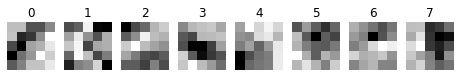

Activations layer 3:


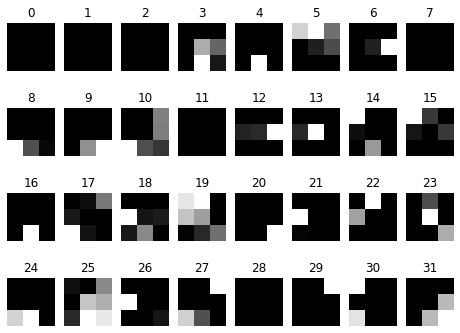

In [ ]:
plot_filters_layer1(model)
plot_activations_layer3(model,test_image)

### Display loss curves
Just included for completeness. Verify that the model is not overfitting the training data.

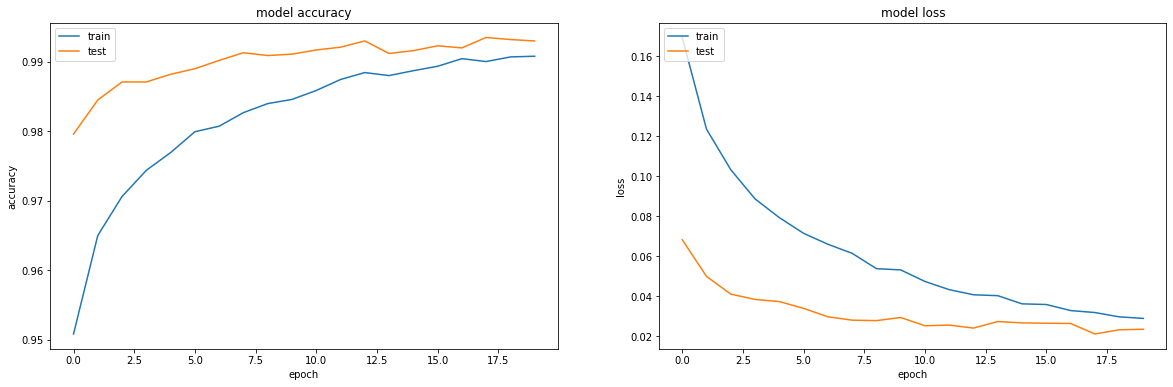

In [ ]:
import matplotlib.pyplot as plt

def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

show_history(history)

### Optional task
Try to visualize the FC layers using K-NN or t-SNE

# Optional task (advanced) - Implement saliency via occlusion
Read about "Saliency via occlusion" in the slides of lecture 10. Then implement the technique for VGG16 and test it on the first cat image.

I used a window size of 56 pixels and a stride of 8 in my solution.

Here is some code to get you started:

In [ ]:
img_path = '/content/gdrive/My Drive/cat.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data.copy())
print(img_preprocessed.shape)

predictions = vgg16_full.predict(img_preprocessed)

labels = decode_predictions(predictions,top=1)
[print(name,prob) for code, name, prob in labels[0]]

class_index = np.argmax(predictions)
print(class_index)

prob = predictions[0,class_index]
print(prob)

(1, 224, 224, 3)
tiger_cat 0.41843152
282
0.41843152


In [ ]:
stride = 8
W = 56
N = (224 - W) // stride
heat_map = np.zeros((N,N))

for xi in range(N):
  print(xi,N)
  x = xi*stride
  for yi in range(N):
    y = yi*stride

    # occlusion
    img_input = img_preprocessed.copy()
    img_input[0,x:x+W,y:y+W,:] = 0

    # get probability of tiger cat
    predictions = vgg16_full.predict(img_input)
    heat_map[xi,yi] = predictions[0,class_index].squeeze()

0 21
1 21
2 21
3 21
4 21
5 21
6 21
7 21
8 21
9 21
10 21
11 21
12 21
13 21
14 21
15 21
16 21
17 21
18 21
19 21
20 21


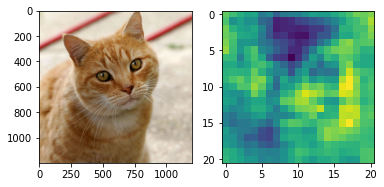

In [ ]:
img = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
plt.subplot(121);plt.imshow(img);
plt.subplot(122);plt.imshow(heat_map);